<a href="https://colab.research.google.com/github/UmbraSpirits/fcc_book_recommendation/blob/master/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2020-08-19 11:54:29--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.248.60.43, 104.248.63.248, 2604:a880:400:d1::86d:6001, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.248.60.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.7’

book-crossings.zip. 100%[===================>]  24.88M  3.40MB/s    in 7.3s    

2020-08-19 11:54:36 (3.39 MB/s) - ‘book-crossings.zip.7’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [ ]:
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [ ]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


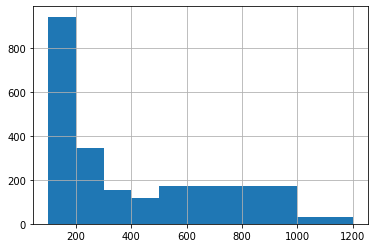

In [ ]:
df_ratings.groupby(["user"]).count().rating.hist(bins=[100, 200, 300, 400, 500, 1000, 1200 ])
plt.show()

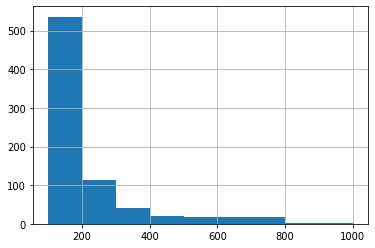

In [ ]:
df_ratings.groupby(["isbn"]).count().rating.hist(bins=[100, 200, 300, 400, 500, 800, 1000])
plt.show()

In [ ]:
# # Filtering the data so books have an appropriate amount of rating first I used the code below to create a filter... but that is a filter on a filter. So create dummy variables first and filter on those.
# df_ratings_new = df_ratings.groupby(["user"]).filter(lambda x: x['rating'].count()>=200)
# df_ratings_new = df_ratings_new.groupby(["isbn"]).filter(lambda x: x['rating'].count()>=100)

df_ratings_new = df_ratings
df_ratings_new["amountOfUsers"] = df_ratings_new["rating"].groupby(df_ratings_new["user"]).transform("count")
df_ratings_new["amountOfBooks"] = df_ratings_new["rating"].groupby(df_ratings_new["isbn"]).transform("count")

userFilter = df_ratings_new["amountOfUsers"] >= 200
isbnFilter = df_ratings_new["amountOfBooks"] >= 100

df_ratings_new = df_ratings_new[userFilter]
df_ratings_new = df_ratings_new[isbnFilter]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [ ]:
df_ratings_new.head()

,user,isbn,rating,amountOfUsers,amountOfBooks
1456,277427,002542730X,10.0,497,171
1469,277427,0060930535,0.0,497,494
1471,277427,0060934417,0.0,497,350
1474,277427,0061009059,9.0,497,291
1484,277427,0140067477,0.0,497,189


In [ ]:
print(df_ratings_new)

           user        isbn  rating  amountOfUsers  amountOfBooks
1456     277427  002542730X    10.0            497            171
1469     277427  0060930535     0.0            497            494
1471     277427  0060934417     0.0            497            350
1474     277427  0061009059     9.0            497            291
1484     277427  0140067477     0.0            497            189
...         ...         ...     ...            ...            ...
1147304  275970  0804111359     0.0           1376            167
1147436  275970  140003065X     0.0           1376            157
1147439  275970  1400031346     0.0           1376            106
1147440  275970  1400031354     0.0           1376            202
1147441  275970  1400031362     0.0           1376            128

[49781 rows x 5 columns]


In [ ]:
testing = df_ratings_new.groupby(["isbn"]).count()
print(testing)

            user  rating  amountOfUsers  amountOfBooks
isbn                                                  
002542730X    80      80             80             80
0060008032    49      49             49             49
0060096195    45      45             45             45
006016848X    54      54             54             54
0060173289    31      31             31             31
...          ...     ...            ...            ...
1573227331    25      25             25             25
1573229326    55      55             55             55
1573229571    29      29             29             29
1592400876    49      49             49             49
1878424319    40      40             40             40

[731 rows x 4 columns]


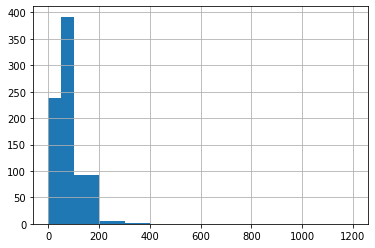

In [ ]:
testing.rating.hist(bins=[0, 50, 100, 200, 300, 400, 500, 1000, 1200 ])
plt.show()

In [ ]:
testing2 = df_ratings_new.groupby(["user"]).count()
print(testing2)

        isbn  rating  amountOfUsers  amountOfBooks
user                                              
254       51      51             51             51
2276      28      28             28             28
2766      38      38             38             38
2977      16      16             16             16
3363      78      78             78             78
...      ...     ...            ...            ...
275970    81      81             81             81
277427    79      79             79             79
277478    15      15             15             15
277639    19      19             19             19
278418   105     105            105            105

[888 rows x 4 columns]


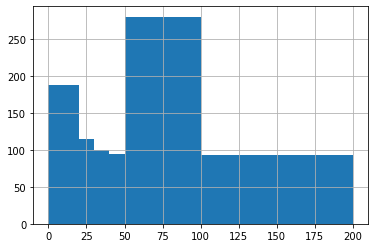

In [ ]:
testing2.rating.hist(bins=[0, 20, 30, 40, 50, 100, 200])
plt.show()

In [ ]:
testing2.describe()

,isbn,rating,amountOfUsers,amountOfBooks
count,888.000000,888.000000,888.000000,888.000000
mean,56.059685,56.059685,56.059685,56.059685
std,52.103356,52.103356,52.103356,52.103356
min,1.000000,1.000000,1.000000,1.000000
25%,22.750000,22.750000,22.750000,22.750000
50%,43.000000,43.000000,43.000000,43.000000
75%,74.000000,74.000000,74.000000,74.000000
max,660.000000,660.000000,660.000000,660.000000


In [ ]:
# Combining the datasets
df_book_ratings = pd.merge(df_books, df_ratings_new, on="isbn")

In [ ]:
df_book_ratings.head()

,isbn,title,author,user,rating,amountOfUsers,amountOfBooks
0,0440234743,The Testament,John Grisham,277478,0.0,214,422
1,0440234743,The Testament,John Grisham,2977,0.0,232,422
2,0440234743,The Testament,John Grisham,3363,0.0,901,422
3,0440234743,The Testament,John Grisham,7346,9.0,1007,422
4,0440234743,The Testament,John Grisham,9856,0.0,201,422


In [ ]:
df_ratingCount = (df_book_ratings.
                  groupby(by = ["title"])["rating"].
                  count().
                  reset_index().
                  rename(columns = {"rating": "totalRating"})
                  )

In [ ]:
df_ratingCount.head()

,title,totalRating
0,1984,52
1,1st to Die: A Novel,162
2,2nd Chance,123
3,4 Blondes,72
4,A Beautiful Mind: The Life of Mathematical Gen...,46


In [ ]:
df_base_and_ratingCount = df_book_ratings.merge(df_ratingCount, left_on="title", right_on="title", how="left")

In [ ]:
df_base_and_ratingCount.head()

,isbn,title,author,user,rating,amountOfUsers,amountOfBooks,totalRating
0,0440234743,The Testament,John Grisham,277478,0.0,214,422,165
1,0440234743,The Testament,John Grisham,2977,0.0,232,422,165
2,0440234743,The Testament,John Grisham,3363,0.0,901,422,165
3,0440234743,The Testament,John Grisham,7346,9.0,1007,422,165
4,0440234743,The Testament,John Grisham,9856,0.0,201,422,165


In [ ]:
print(df_base_and_ratingCount)

             isbn  ... totalRating
0      0440234743  ...         165
1      0440234743  ...         165
2      0440234743  ...         165
3      0440234743  ...         165
4      0440234743  ...         165
...           ...  ...         ...
49512  0515135739  ...          40
49513  0515135739  ...          40
49514  0515135739  ...          40
49515  0515135739  ...          40
49516  0515135739  ...          40

[49517 rows x 8 columns]


In [ ]:
df_base_and_ratingCount = df_base_and_ratingCount.drop_duplicates(["user", "title"])
print(df_base_and_ratingCount)

             isbn  ... totalRating
0      0440234743  ...         165
1      0440234743  ...         165
2      0440234743  ...         165
3      0440234743  ...         165
4      0440234743  ...         165
...           ...  ...         ...
49512  0515135739  ...          40
49513  0515135739  ...          40
49514  0515135739  ...          40
49515  0515135739  ...          40
49516  0515135739  ...          40

[49136 rows x 8 columns]


In [ ]:
df_base_and_ratingCount_pivot = df_base_and_ratingCount.pivot(index = "title", columns = 'user', values = 'rating').fillna(0)

In [ ]:
df_base_and_ratingCount_matrix = csr_matrix(df_base_and_ratingCount_pivot.values)

In [ ]:
model_knn = NearestNeighbors(metric = "cosine", algorithm = "brute")
model_knn.fit(df_base_and_ratingCount_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  query_index = df_base_and_ratingCount_pivot.index.get_loc(book)
  distances, indices = model_knn.kneighbors(df_base_and_ratingCount_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)

  recommended_books = [book, []]

  for i in range(1, len(distances.flatten())):
    recommended_books[1].append([df_base_and_ratingCount_pivot.index[indices.flatten()[i]], distances.flatten()[i]])

  recommended_books[1] = list(reversed(recommended_books[1])) 

  return recommended_books

In [ ]:
get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")

['The Queen of the Damned (Vampire Chronicles (Paperback))',
 [['Catch 22', 0.7939835],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.74486566],
  ['Interview with the Vampire', 0.73450685],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.53763384],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.51784116]]]

Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You havn't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
